In [54]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import entropy
from scipy.io import mmread
from scipy.sparse.linalg import eigs

In [3]:
def get_stationary(P_trans, K=100):
    stationary = np.ones(P_trans.shape[0])
    for i in range(K):
        stationary = stationary @ P_trans
    return stationary / np.sum(stationary)

def sample_rws(P_trans, M=1000, T=16):
    """ Sample M random walks of length T with uniform choice of start node."""
    N = P_trans.shape[0]
    random_walks = np.zeros((M, T+1), dtype=np.int)
    for i in range(M):
        random_walks[i, 0] = np.random.choice(N)
        for t in range(T):
            random_walks[i, t + 1] = np.random.choice(N, p=P_trans[random_walks[i, t]])
    return random_walks

def build_score_matrix(random_walks, N):
    M, T = np.shape(random_walks)
    score_matrix = np.zeros((N,N))
    for i in range(M):
        for j in range(T-1):
            score_matrix[random_walks[i, j], random_walks[i, j+1]] += 1

    score_matrix = score_matrix / score_matrix.sum()
    p_rws = score_matrix.sum(axis=-1)
    return score_matrix, p_rws

def main(P_trans, M, T_max):
    """ Compares start node distribution in score matrix, which is obtained by random walks, 
        with the mixture of corresponding stationary distribution and uniform.

    Args:
        P_trans: square transition matrix, from which random walks are drawn.
        M: amount of random walks.
        T_max: consider random walks up to length T_max.
    
    Returns:
        Plot of best mixture parameter against length T of the random walks."""
    
    N = P_trans.shape[0]
    
    p_stat = get_stationary(P_trans)
    p_unif = np.ones(N) / N
    
    Ts = np.arange(1,T_max + 1)
    rhos = np.arange(0,1,0.01)
    KLs = np.zeros_like(rhos)

    rho_optims = np.zeros_like(Ts, dtype=np.float32)
    KL_optims = np.zeros_like(Ts, dtype=np.float32)
    KL_joints = np.zeros_like(Ts, dtype=np.float32)
    
    for T in Ts:        
        random_walks = sample_rws(P_trans=P_trans, M=M, T=T)
        score_matrix, p_rws = build_score_matrix(random_walks=random_walks, N=N)
        
        for i in range(len(rhos)):
            KLs[i] = entropy(p_rws, rhos[i] * p_stat + (1 - rhos[i]) * p_unif)
        best_rho = rhos[np.argmin(KLs)]
        rho_optims[T - 1] = best_rho
        KL_optims[T - 1] = np.min(KLs)
        
        # Use best marginal mixture to compute joint distribution
        score_approx = np.diag(best_rho * p_stat + (1 - best_rho) * p_unif) @ P_trans
        KL_joints[T - 1] = entropy(score_matrix.flatten(), score_approx.flatten())
        
    # Plot results against T
    f, axs = plt.subplots(1, 3, sharex=True, figsize=(18,12))
    plt.tight_layout(pad=5)
    f.suptitle('How well does a mixture of stationary and uniform approximate the true score matrix?')

    axs[0].plot(Ts, rho_optims)
    axs[1].plot(Ts, np.log(KL_optims))
    axs[2].plot(Ts, np.log(KL_joints))
    
    axs[0].set_title('Best mixing parameter')
    axs[1].set_title('KL-divergence between marginals')
    axs[2].set_title('KL-divergence between joints')
    
    axs[0].set_ylabel(r'$\rho$')
    axs[1].set_ylabel('KL-divergence (log scale)')
    axs[2].set_ylabel('KL-divergence (log scale)')
    f.text(0.5, 0.04, 'Ts', ha='center')
    return rho_optims, KL_optims, KL_joints

# Example: Zachary's karate club

In [5]:
G = mmread('../data/soc-karate.mtx')
A = G.todense()

D = np.diag(np.array(1 / np.sum(A, axis=-1)).flatten())
P_trans = np.array(D @ A)

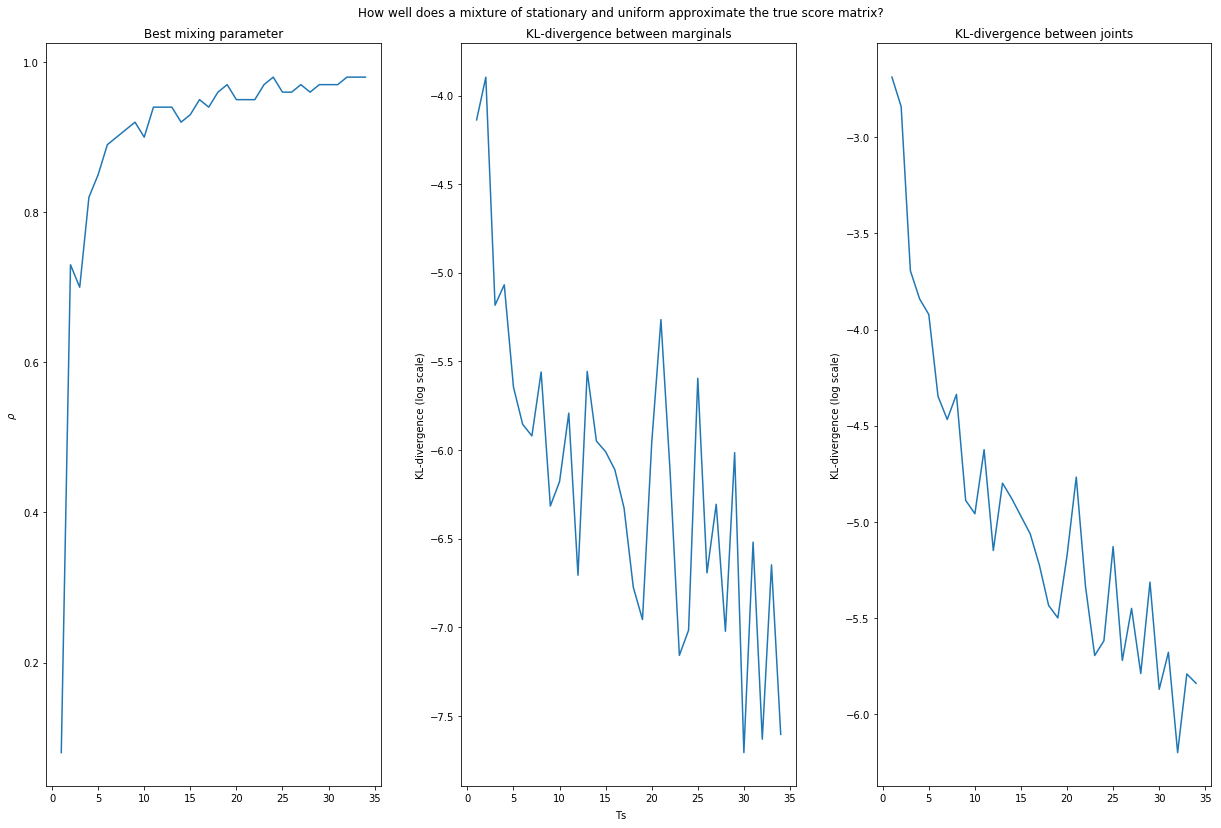

In [6]:
rho_optims, KL_optims, KL_joints = main(P_trans=P_trans, M=1000, T_max=34)

## Conclusion:
Due to the small world property of real-world networks, the starting node distribution is already for small T close to the stationary distribution. The corresponding score matrix is then a good approximation to the score matrix, built with random walks.

# Sample random walks and build score matrix & node distribution

In [148]:
# Initialize values and transition matrix
N = 5
M = 1000
T = 100
alpha = 0.2

P_trans = np.random.dirichlet(alpha * np.ones(N), size=N)

In [149]:
random_walks = sample_rws(P_trans=P_trans, M=M, T=T)
score_matrix, p_rws = build_score_matrix(random_walks=random_walks, N=N)

# Compare node distribution $p_\text{rws}$ with stationary distribution $p_\text{stat}$:
$p_\text{rws}$ is the left marginal distribution of transitions $(x_i, y_i)$. This already defines the distribution for the full score matrix, since the likelihood $f(y_i | x_i)$ is (at least in the limit, because of finite sampling effects) given by the transition function $P_\text{trans}$.

In formulas, the score matrix score_matrix is approximately given by

$$
\text{score_matrix} \approx \text{diag}(p_\text{rws})P_\text{trans}
$$


Presumably, $p_\text{rws}$ is a mixture of the uniform distribution (for small $T$) and the stationary distribution (for large $T$). Compute the optimal mixture parameter in terms of KL divergence.

$$
p_\rho = \rho p_\text{stat} + (1-\rho)p_\text{unif}\,.
$$

The optimal mixture parameter $\rho^\ast$ is then given by

$$
\rho^\ast = \text{argmin}\text{KL}(p_\text{rws} || p_\rho)\,,
$$

which yields the best approximation

$$
p_\text{rws} \approx p_{\rho^\ast}= \rho p_\text{stat} + (1-\rho)p_\text{unif}\,.
$$


In [152]:
p_stat = get_stationary(P_trans)
p_unif = np.ones(N) / N

In [179]:
rhos = np.arange(0,1,0.01)
KLs = np.zeros_like(rhos)

for i in range(len(rhos)):
    KLs[i] = entropy(p_rws, rhos[i] * p_stat + (1 - rhos[i]) * p_unif)
i_optim = np.argmin(KLs)
rho_optim = rhos[i_optim]

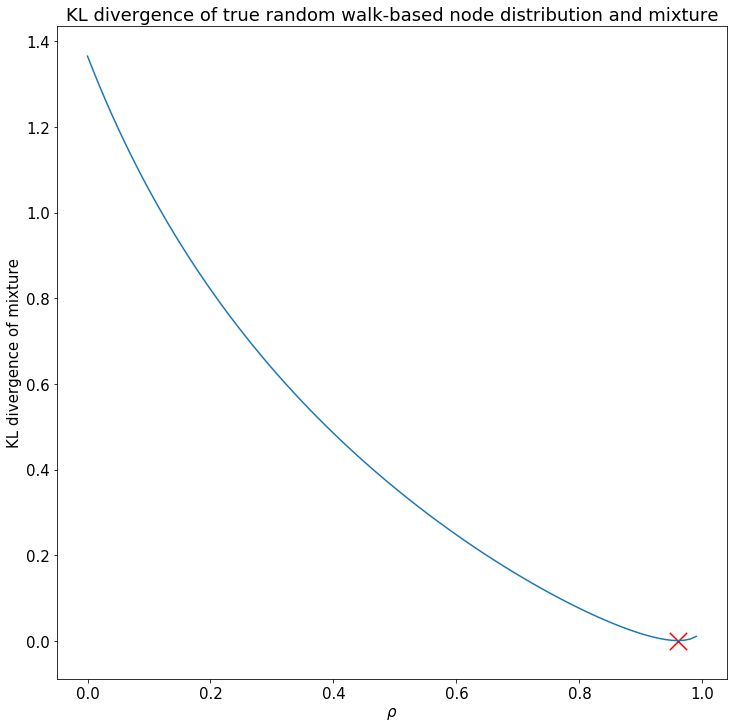

In [192]:
plt.rcParams.update({'font.size': 15})

f = plt.figure(figsize=(12,12))
plt.tight_layout()

plt.plot(rhos, KLs)
plt.scatter(rhos[i_optim], KLs[i_optim], marker='x', color='red', s=300)
plt.title('KL divergence of true random walk-based node distribution and mixture')
plt.xlabel(r'$\rho$')
plt.ylabel('KL divergence of mixture')
plt.show()

# ------------------------------------------------------------------------------

# Buid score matrix from transition matrix

## NetGAN version: score matrix from random walks

In [ ]:
def score_matrix_from_random_walks(random_walks, N, symmetric=True):
    """
    Compute the transition scores, i.e. how often a transition occurs, for all node pairs from
    the random walks provided.
    Parameters
    ----------
    random_walks: np.array of shape (n_walks, rw_len, N)
                  The input random walks to count the transitions in.
    N: int
       The number of nodes
    symmetric: bool, default: True
               Whether to symmetrize the resulting scores matrix.

    Returns
    -------
    scores_matrix: sparse matrix, shape (N, N)
                   Matrix whose entries (i,j) correspond to the number of times a transition from node i to j was
                   observed in the input random walks.

    """

    random_walks = np.array(random_walks)
    bigrams = np.array(list(zip(random_walks[:, :-1], random_walks[:, 1:])))
    bigrams = np.transpose(bigrams, [0, 2, 1])
    bigrams = bigrams.reshape([-1, 2])
    if symmetric:
        bigrams = np.row_stack((bigrams, bigrams[:, ::-1]))

    mat = sp.coo_matrix((np.ones(bigrams.shape[0]), (bigrams[:, 0], bigrams[:, 1])),
                        shape=[N, N])
    return mat

## Our version: score matrix from transition matrix

In [80]:
import numpy as np
from scipy.sparse.linalg import eigs

def score_matrix_from_transition_matrix(transition_matrix, samples=[], symmetric=True):
    """
    Compute the transition scores, i.e. the probability of a transition, for all node pairs from
    the transition matrix provided.
    Parameters
    ----------
    transition_matrix: np.array of shape (N, N)
                  The input transition matrix to count the transitions in.
    samples: integer
               If provided, scales the output to a score matrix that is comparable with the one obtained
               obtained from sampling random walks.
    symmetric: bool, default: True
               Whether to symmetrize the resulting scores matrix.

    Returns
    -------
    scores_matrix: sparse matrix, shape (N, N)
                   Matrix whose entries (i,j) correspond to the probability of a transition from node i to j 
                   for sampling random walks from the transition matrix provided. If samples is given, corresponds
                   to the expected number of transitions.

    """

    p_stationary = np.real(eigs(transition_matrix.T, k=1, sigma=1)[1])
    scores_matrix = p_stationary * P_trans
    
    if symmetric:
        scores_matrix += scores_matrix.T
    
    if samples: 
        scores_matrix *= samples
    
    return scores_matrix

In [81]:
scores_matrix = score_matrix_from_transition_matrix(transition_matrix=P_trans)

In [82]:
scores_matrix

array([[-3.07648133e-05, -3.37528116e-08, -4.63730103e-06, ...,
        -4.03857259e-05, -4.03583945e-06, -2.20345730e-05],
       [-3.37528116e-08, -1.97333676e-05, -3.51691989e-06, ...,
        -5.99552735e-06, -3.18932450e-09, -1.42999008e-05],
       [-4.63730103e-06, -3.51691989e-06, -7.20325557e-07, ...,
        -1.74175510e-06, -2.15630096e-05, -1.47858325e-05],
       ...,
       [-4.03857259e-05, -5.99552735e-06, -1.74175510e-06, ...,
        -1.87360762e-06, -5.04233345e-05, -3.05243428e-07],
       [-4.03583945e-06, -3.18932450e-09, -2.15630096e-05, ...,
        -5.04233345e-05, -1.46242674e-08, -4.65303178e-07],
       [-2.20345730e-05, -1.42999008e-05, -1.47858325e-05, ...,
        -3.05243428e-07, -4.65303178e-07, -1.82581871e-06]])